In [2]:
# Install necessary libraries silently
!pip install pandas scikit-learn Flask pyngrok matplotlib seaborn nest-asyncio --quiet

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import os
from flask import Flask, request, jsonify
from pyngrok import ngrok, conf
import nest_asyncio
import matplotlib.pyplot as plt
import seaborn as sns

# Apply nest_asyncio for compatibility with environments like Colab
nest_asyncio.apply()

print("Libraries installed and imported successfully.")


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
Matplotlib is building the font cache; this may take a moment.


Libraries installed and imported successfully.


In [4]:

try:
    # Adjust path for local execution if running notebook from 'notebook/' dir
    if os.path.exists('../data/personality_dataset.csv'):
        df = pd.read_csv('../data/personality_dataset.csv')
        print("Dataset loaded successfully from ../data/.")
    else:
        df = pd.read_csv('personality_dataset.csv') # For Colab default or root dir
        print("Dataset loaded successfully from current directory.")
except FileNotFoundError:
    print("Error: 'personality_dataset.csv' not found.")
    
    # Create a dummy DataFrame for demonstration if file not found
    data = {
        'Time_spent_Alone': [5.0, 2.0, 8.0, 3.0, 6.0, 4.0, 1.0, 9.0, None, 7.0],
        'Stage_fear': ['No', 'Yes', 'No', 'No', 'Yes', 'No', 'No', 'Yes', 'No', 'Yes'],
        'Social_event_attendance': [7.0, 9.0, 2.0, 8.0, 3.0, 6.0, 9.0, 1.0, 5.0, None],
        'Going_outside': [4.0, 6.0, 1.0, 5.0, 2.0, 5.0, 7.0, 0.0, None, 3.0],
        'Drained_after_socializing': ['No', 'No', 'Yes', 'No', 'Yes', 'No', 'No', 'Yes', 'Yes', 'No'],
        'Friends_circle_size': [10.0, 12.0, 3.0, 9.0, 5.0, 8.0, 11.0, 2.0, None, 6.0],
        'Post_frequency': [8.0, 9.0, 1.0, 7.0, 2.0, 6.0, 10.0, 0.0, 4.0, None],
        'Personality': ['Extrovert', 'Extrovert', 'Introvert', 'Extrovert', 'Introvert', 'Extrovert', 'Extrovert', 'Introvert', 'Introvert', 'Extrovert']
    }
    df = pd.DataFrame(data)
    print("Using a dummy dataset for demonstration purposes as the actual file was not found.")

# Display the first few rows and information about the dataset
print("\nDataset Head:")
print(df.head())
print("\nDataset Info:")
df.info()

Dataset loaded successfully from ../data/.

Dataset Head:
   Time_spent_Alone Stage_fear  Social_event_attendance  Going_outside  \
0               4.0         No                      4.0            6.0   
1               9.0        Yes                      0.0            0.0   
2               9.0        Yes                      1.0            2.0   
3               0.0         No                      6.0            7.0   
4               3.0         No                      9.0            4.0   

  Drained_after_socializing  Friends_circle_size  Post_frequency Personality  
0                        No                 13.0             5.0   Extrovert  
1                       Yes                  0.0             3.0   Introvert  
2                       Yes                  5.0             2.0   Introvert  
3                        No                 14.0             8.0   Extrovert  
4                        No                  8.0             5.0   Extrovert  

Dataset Info:
<class '

In [3]:
# Load the dataset
# Adjust path based on execution environment (Colab vs. local project structure)
try:
    # If running from 'notebook/' directory in a local project
    if os.path.exists('../data/personality_dataset.csv'):
        df = pd.read_csv('../data/personality_dataset.csv')
        print("Dataset loaded successfully from ../data/.")
    else:
        # Assumes file is in the same directory (common for Colab uploads)
        df = pd.read_csv('personality_dataset.csv')
        print("Dataset loaded successfully from current directory.")
except FileNotFoundError:
    print("Error: 'personality_dataset.csv' not found.")
    print("Please upload the dataset file to your Colab environment or place it in the 'data/' directory if running locally.")
    print("You can download it from: https://www.kaggle.com/datasets/hardikchhipa28/personality-dataset-introvert-or-extrovert")
    raise # Re-raise the error to stop execution if the file is genuinely not found.


# Display basic information about the dataset
print("\nDataset Head:")
print(df.head())
print("\nDataset Info:")
df.info()
print("\nDataset Description (Numerical Features):")
print(df.describe())


Dataset loaded successfully from ../data/.

Dataset Head:
   Time_spent_Alone Stage_fear  Social_event_attendance  Going_outside  \
0               4.0         No                      4.0            6.0   
1               9.0        Yes                      0.0            0.0   
2               9.0        Yes                      1.0            2.0   
3               0.0         No                      6.0            7.0   
4               3.0         No                      9.0            4.0   

  Drained_after_socializing  Friends_circle_size  Post_frequency Personality  
0                        No                 13.0             5.0   Extrovert  
1                       Yes                  0.0             3.0   Introvert  
2                       Yes                  5.0             2.0   Introvert  
3                        No                 14.0             8.0   Extrovert  
4                        No                  8.0             5.0   Extrovert  

Dataset Info:
<class '

In [5]:
# Check for missing values in each column
print("\nMissing Values per Column:")
print(df.isnull().sum())


Missing Values per Column:
Time_spent_Alone             63
Stage_fear                   73
Social_event_attendance      62
Going_outside                66
Drained_after_socializing    52
Friends_circle_size          77
Post_frequency               65
Personality                   0
dtype: int64


In [6]:
# Analyze the distribution of the target variable 'Personality'
print("\nPersonality Class Distribution:")
print(df['Personality'].value_counts())
print(df['Personality'].value_counts(normalize=True) * 100) # Percentage distribution


Personality Class Distribution:
Personality
Extrovert    1491
Introvert    1409
Name: count, dtype: int64
Personality
Extrovert    51.413793
Introvert    48.586207
Name: proportion, dtype: float64


In [7]:
# Identify numerical and categorical features for plotting
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
# Exclude 'Personality' from categorical features for general plotting as it's the target
categorical_features_for_plot = [f for f in categorical_features if f != 'Personality']


Visualizing Numerical Feature Distributions (Histograms):


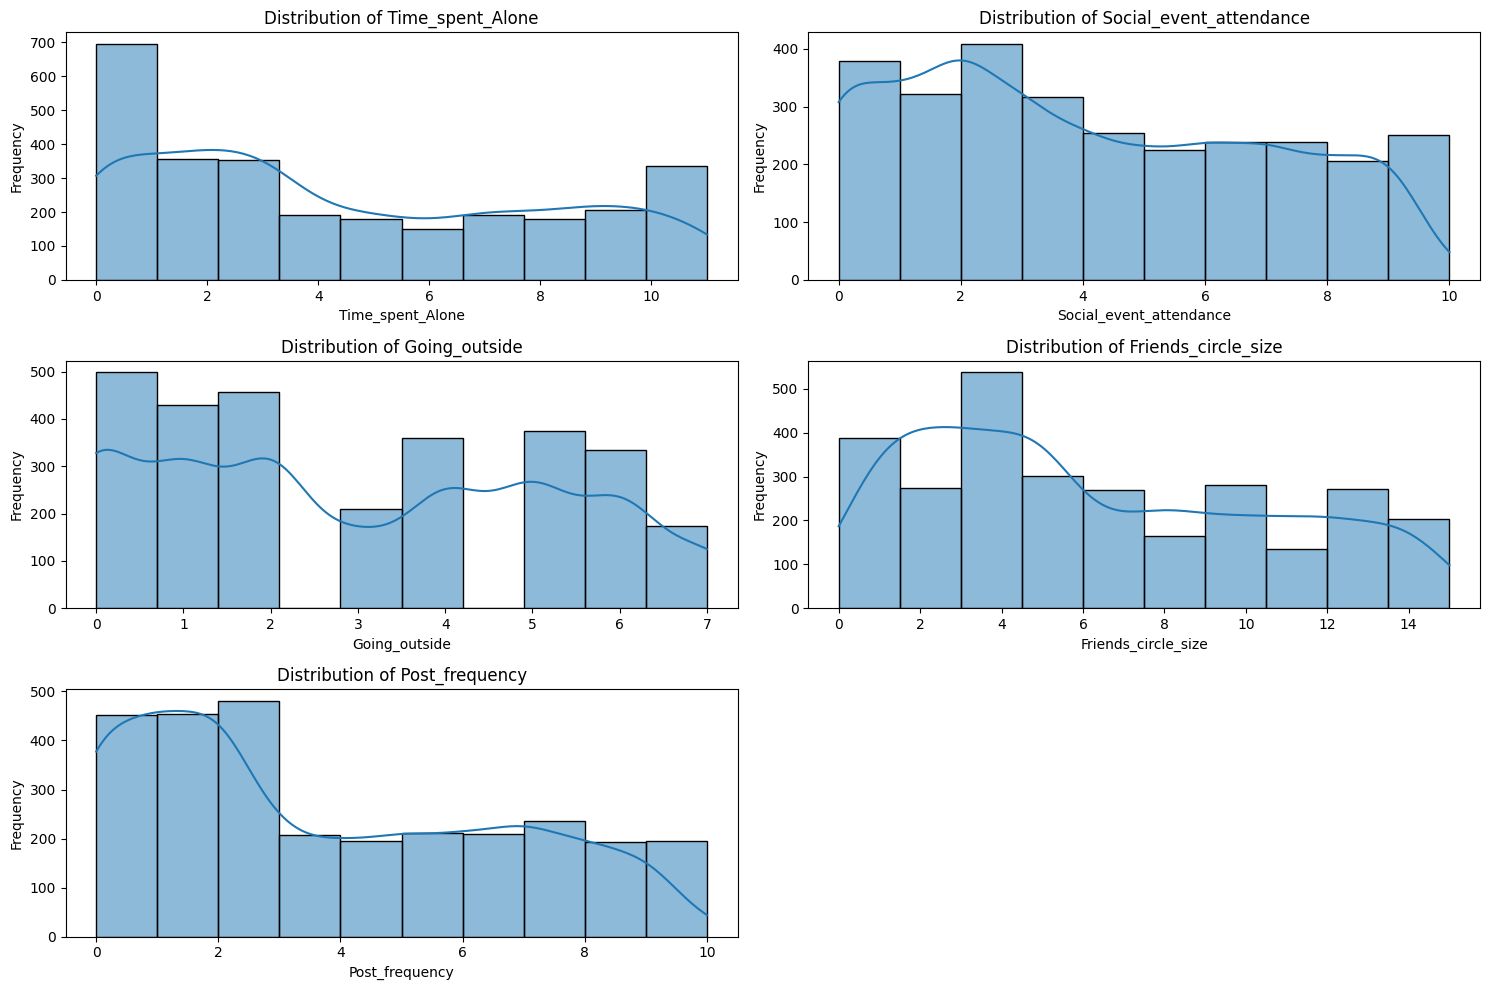

In [8]:
# Visualize distributions of numerical features using histograms
print("\nVisualizing Numerical Feature Distributions (Histograms):")
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features):
    plt.subplot(3, 2, i + 1) # Create a 3x2 grid of subplots
    sns.histplot(df[col], kde=True, bins=10) # Use kde for density estimation
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show()


Visualizing Categorical Feature Distributions (Bar Plots):


C:\Users\Nuwanga Wijamuni\AppData\Local\Temp\ipykernel_4972\1716678115.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='viridis')
C:\Users\Nuwanga Wijamuni\AppData\Local\Temp\ipykernel_4972\1716678115.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='viridis')


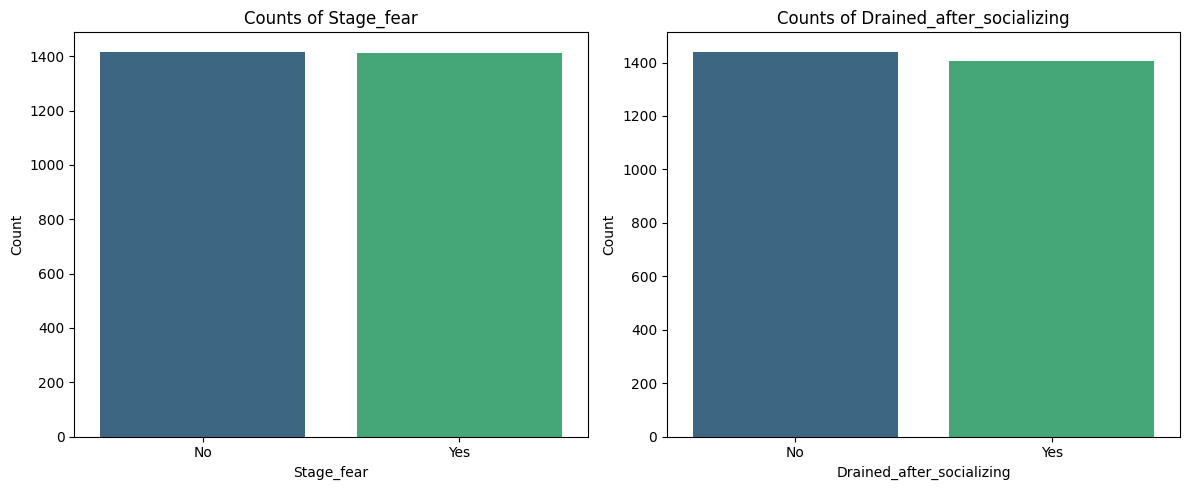

In [9]:
# Visualize distributions of categorical features using bar plots
print("\nVisualizing Categorical Feature Distributions (Bar Plots):")
if categorical_features_for_plot:
    plt.figure(figsize=(12, 5))
    for i, col in enumerate(categorical_features_for_plot):
        plt.subplot(1, 2, i + 1)
        sns.countplot(x=col, data=df, palette='viridis')
        plt.title(f'Counts of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
else:
    print("No categorical features (excluding 'Personality') to plot.")


Correlation Matrix of Numerical Features (Pairwise correlation, NaNs dropped for calculation):


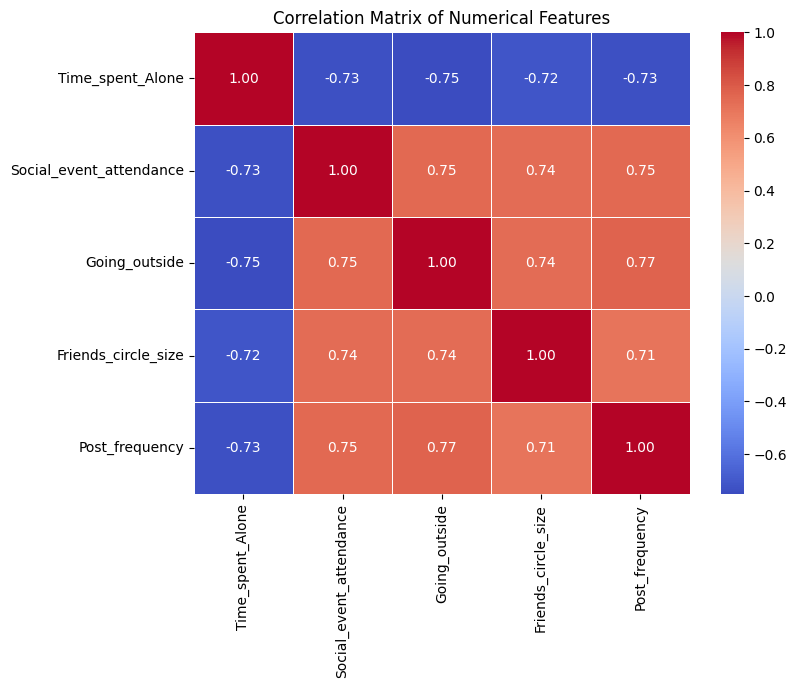


Visualizing Numerical Features vs. Personality (Box Plots):


C:\Users\Nuwanga Wijamuni\AppData\Local\Temp\ipykernel_4972\164306449.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Personality', y=col, data=df, palette='pastel')
C:\Users\Nuwanga Wijamuni\AppData\Local\Temp\ipykernel_4972\164306449.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Personality', y=col, data=df, palette='pastel')
C:\Users\Nuwanga Wijamuni\AppData\Local\Temp\ipykernel_4972\164306449.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Personality', y=col, data=df, palette='pastel')
C:\Users\Nuwanga Wijamuni

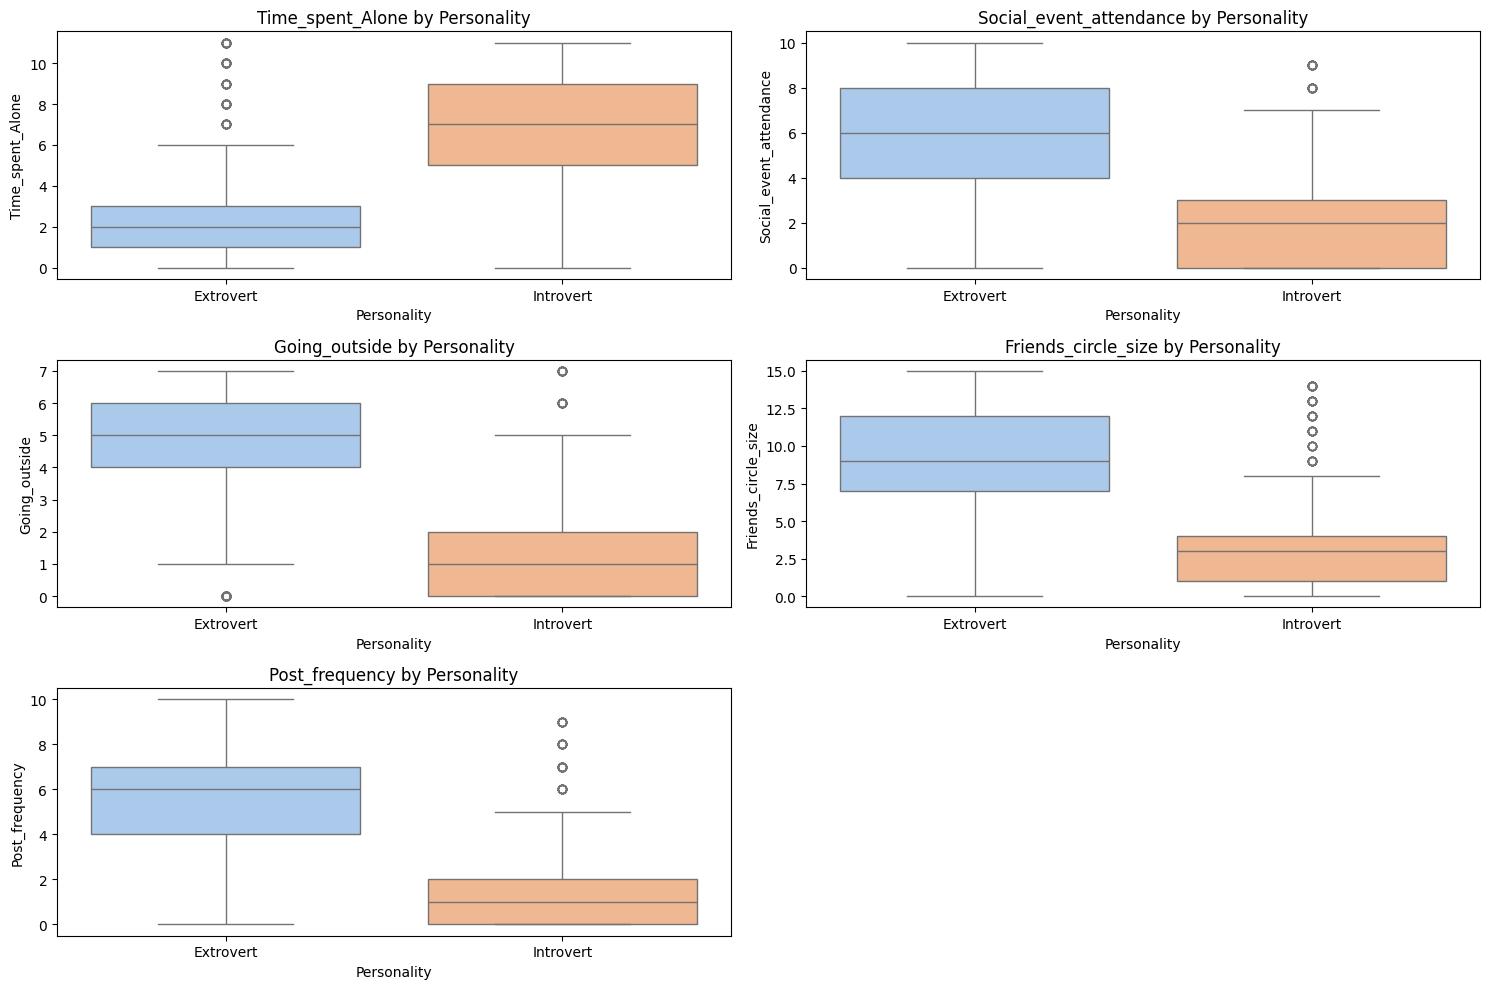

In [10]:
# Visualize correlation matrix for numerical features
# First, create a temporary DataFrame with numerical features and drop NaNs for accurate correlation calculation
df_numeric_for_corr = df[numerical_features].dropna()
print("\nCorrelation Matrix of Numerical Features (Pairwise correlation, NaNs dropped for calculation):")
plt.figure(figsize=(8, 6))
sns.heatmap(df_numeric_for_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Visualize relationships between numerical features and the target variable (using box plots)
print("\nVisualizing Numerical Features vs. Personality (Box Plots):")
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features):
    plt.subplot(3, 2, i + 1)
    sns.boxplot(x='Personality', y=col, data=df, palette='pastel')
    plt.title(f'{col} by Personality')
    plt.xlabel('Personality')
    plt.ylabel(col)
plt.tight_layout()
plt.show()


Visualizing Categorical Features vs. Personality (Count Plots):


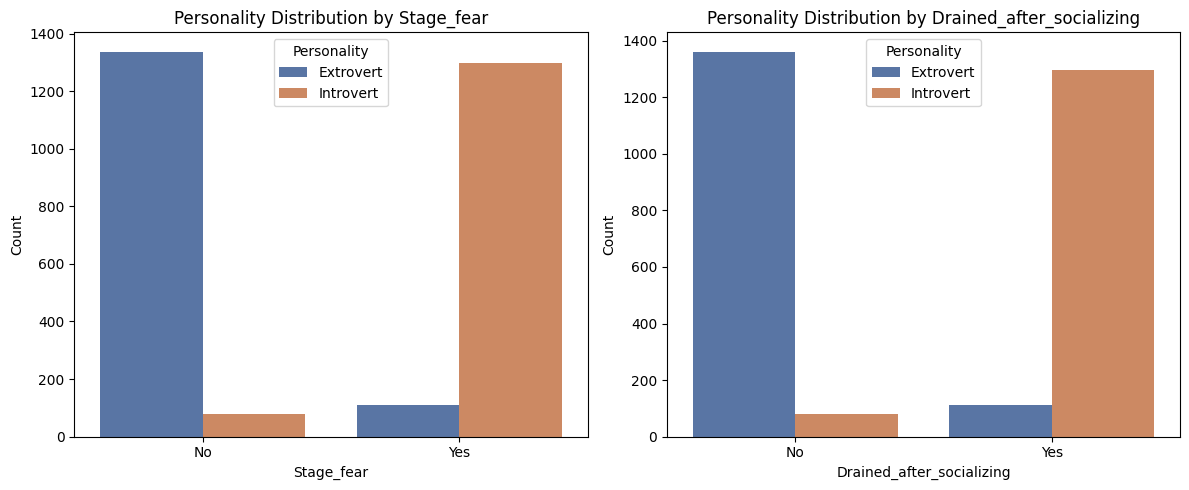


EDA complete. Insights gathered to inform preprocessing and modeling.


In [11]:
# Visualize relationships between categorical features and the target variable (using stacked bar plots)
print("\nVisualizing Categorical Features vs. Personality (Count Plots):")
if categorical_features_for_plot:
    plt.figure(figsize=(12, 5))
    for i, col in enumerate(categorical_features_for_plot):
        plt.subplot(1, 2, i + 1)
        sns.countplot(x=col, hue='Personality', data=df, palette='deep')
        plt.title(f'Personality Distribution by {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.legend(title='Personality')
    plt.tight_layout()
    plt.show()

print("\nEDA complete. Insights gathered to inform preprocessing and modeling.")

In [12]:
# Separate features (X) and target (y)
X = df.drop('Personality', axis=1)
y = df['Personality']

# Identify column types
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

In [13]:
# Pre-encode binary categorical columns in X.
# This step is crucial because the ColumnTransformer expects numerical inputs for scaling.
# LabelEncoder is applied directly to transform 'Yes'/'No' to 1/0.
print("\nPre-encoding binary categorical features in X:")
for col in categorical_cols:
    le = LabelEncoder()
    # Fill NaN with a placeholder string to allow LabelEncoder to fit without error.
    # The imputer within the ColumnTransformer will handle this 'Missing' category later if needed,
    # or ensure a consistent numeric representation.
    X[col] = X[col].fillna('Missing_Category').astype(str)
    X[col] = le.fit_transform(X[col])
    # Print mapping for verification
    print(f"  '{col}' mapping: {list(zip(le.classes_, le.transform(le.classes_)))}")


Pre-encoding binary categorical features in X:
  'Stage_fear' mapping: [('Missing_Category', np.int64(0)), ('No', np.int64(1)), ('Yes', np.int64(2))]
  'Drained_after_socializing' mapping: [('Missing_Category', np.int64(0)), ('No', np.int64(1)), ('Yes', np.int64(2))]


In [14]:
# Define preprocessing steps for numerical features (which now include pre-encoded categoricals)
# Impute missing numerical values with the median (robust to outliers), then apply StandardScaler
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Handles numerical NaNs (including from pre-encoded 'Missing_Category')
    ('scaler', StandardScaler()) # Scales all numerical features to a standard range
])

In [15]:
# Create a ColumnTransformer to apply the numerical_transformer to all columns (since all are now numerical)
# The order of features passed to the ColumnTransformer is important for consistent input to the model.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols + categorical_cols) # Apply to all original numerical and now-numerical categorical columns
    ],
    remainder='passthrough' # Ensures no columns are accidentally dropped if not explicitly handled
)

In [16]:
# Encode the target variable 'Personality' ('Introvert'/'Extrovert' to 0/1)
le_personality = LabelEncoder()
y_encoded = le_personality.fit_transform(y)
print(f"\nTarget variable 'Personality' encoded to numerical classes: {list(zip(le_personality.classes_, le_personality.transform(le_personality.classes_)))}\n")


Target variable 'Personality' encoded to numerical classes: [('Extrovert', np.int64(0)), ('Introvert', np.int64(1))]



In [17]:
# Split the dataset into training and testing sets
# Use stratify=y_encoded to ensure proportional representation of Introvert/Extrovert in both sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print("\nData preprocessing setup complete with ColumnTransformer and Pipeline.")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")



Data preprocessing setup complete with ColumnTransformer and Pipeline.
X_train shape: (2320, 7), y_train shape: (2320,)
X_test shape: (580, 7), y_test shape: (580,)


In [18]:
# Create the full model pipeline: Preprocessor followed by Classifier
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), # Applies all defined preprocessing steps
    ('classifier', RandomForestClassifier(random_state=42)) # RandomForestClassifier as the estimator
])


In [19]:
# Define the parameter grid for GridSearchCV.
# These parameters are chosen to explore common tuning options for RandomForest.
param_grid = {
    'classifier__n_estimators': [50, 100, 150],       # Number of decision trees in the forest
    'classifier__max_features': ['sqrt', 'log2'], # Number of features to consider when looking for the best split
    'classifier__max_depth': [None, 10, 20],        # Maximum depth of the tree (None means unlimited)
    'classifier__min_samples_split': [2, 5],        # Minimum number of samples required to split an internal node
    'classifier__min_samples_leaf': [1, 2]          # Minimum number of samples required to be at a leaf node
}

In [20]:
# Set up StratifiedKFold for cross-validation to maintain class balance in folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 5 folds for cross-validation

print("\nStarting GridSearchCV for Hyperparameter Tuning (This may take some time)...")
# Initialize GridSearchCV
#   - estimator: The pipeline to tune
#   - param_grid: The grid of hyperparameters to search
#   - cv: Cross-validation strategy
#   - scoring: Metric to optimize ('accuracy' for this problem)
#   - n_jobs=-1: Use all available CPU cores for parallel processing
#   - verbose: Controls the verbosity of the output
grid_search = GridSearchCV(model_pipeline, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=2)


Starting GridSearchCV for Hyperparameter Tuning (This may take some time)...


In [22]:
# Fit GridSearchCV on the training data. This will perform cross-validation for each parameter combination.
grid_search.fit(X_train, y_train)

print("\nHyperparameter tuning complete.")
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# The best model (pipeline) found by GridSearchCV
best_model = grid_search.best_estimator_


Fitting 5 folds for each of 72 candidates, totalling 360 fits

Hyperparameter tuning complete.
Best parameters found: {'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best cross-validation accuracy: 0.9388


In [23]:
# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)

# Calculate Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"\nFinal Model Accuracy on Test Set: {accuracy:.4f}")


Final Model Accuracy on Test Set: 0.9155


In [24]:
# Generate Classification Report (Precision, Recall, F1-score for each class)
report = classification_report(y_test, y_pred, target_names=le_personality.classes_)
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

   Extrovert       0.94      0.89      0.92       298
   Introvert       0.89      0.94      0.92       282

    accuracy                           0.92       580
   macro avg       0.92      0.92      0.92       580
weighted avg       0.92      0.92      0.92       580



In [25]:
# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix (Raw Counts):\n", conf_matrix)



Confusion Matrix (Raw Counts):
 [[266  32]
 [ 17 265]]


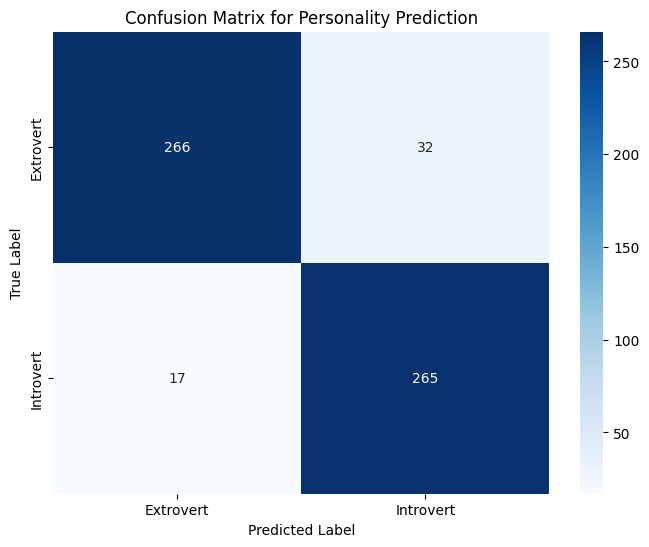

In [26]:
# Visualize Confusion Matrix for better understanding of classification errors
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_personality.classes_, # Labels for predicted classes
            yticklabels=le_personality.classes_) # Labels for true classes
plt.title('Confusion Matrix for Personality Prediction')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


Feature Importances (Sorted Top to Bottom):
                     Feature  Importance
6             Post_frequency    0.267592
5        Friends_circle_size    0.216559
0           Time_spent_Alone    0.147250
4  Drained_after_socializing    0.120797
2    Social_event_attendance    0.108451
1                 Stage_fear    0.105391
3              Going_outside    0.033960


C:\Users\Nuwanga Wijamuni\AppData\Local\Temp\ipykernel_4972\4112636638.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=features_df, palette='magma')


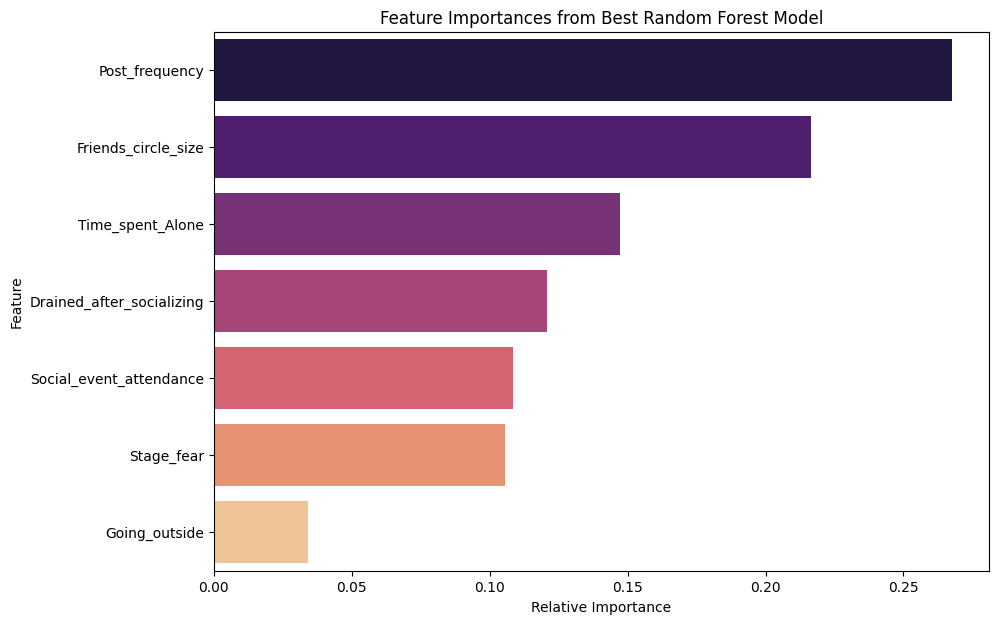


Model evaluation complete, providing a comprehensive understanding of performance.


In [27]:
# Extract and visualize Feature Importances from the best Random Forest Classifier
# Note: Feature importances are from the classifier after preprocessing.
# The order corresponds to the `numerical_cols + categorical_cols` list used in ColumnTransformer.
feature_names_for_importance = numerical_cols + [f"{col}_encoded" for col in categorical_cols] # Renaming for clarity if needed

if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    importances = best_model.named_steps['classifier'].feature_importances_
    # Create a DataFrame for better readability and sorting
    features_df = pd.DataFrame({'Feature': X.columns.tolist(), 'Importance': importances})
    features_df = features_df.sort_values(by='Importance', ascending=False)

    print("\nFeature Importances (Sorted Top to Bottom):")
    print(features_df)

    # Visualize Feature Importances
    plt.figure(figsize=(10, 7))
    sns.barplot(x='Importance', y='Feature', data=features_df, palette='magma')
    plt.title('Feature Importances from Best Random Forest Model')
    plt.xlabel('Relative Importance')
    plt.ylabel('Feature')
    plt.show()
else:
    print("\nFeature importances are not available for the final classifier type in the pipeline.")

print("\nModel evaluation complete, providing a comprehensive understanding of performance.")

In [30]:
# Define paths for saving the model and label encoder relative to the project root.
# If running this notebook from 'notebook/' directory, these paths correctly point to 'models/'.
model_save_path = os.path.join('..', 'models', 'personality_model.joblib')
label_encoder_save_path = os.path.join('..', 'models', 'personality_label_encoder.joblib')

# Create the 'models' directory if it does not already exist.
# Crucial: This now creates the 'models' directory at the project root, not inside 'notebook/'.
os.makedirs(os.path.join('..', 'models'), exist_ok=True)

# Save the best trained model pipeline (includes preprocessor and classifier)
joblib.dump(best_model, model_save_path)
print(f"\nBest trained model pipeline saved to '{model_save_path}'")

# Save the label encoder used for the 'Personality' target variable
joblib.dump(le_personality, label_encoder_save_path)
print(f"Target Label Encoder saved to '{label_encoder_save_path}'")

print("\nModel persistence complete. Files are ready for API deployment.")


Best trained model pipeline saved to '..\models\personality_model.joblib'
Target Label Encoder saved to '..\models\personality_label_encoder.joblib'

Model persistence complete. Files are ready for API deployment.
